In [1]:
from IPython.display import display, Math, Latex

def disp(ex):
    display(Math(latex(ex)))

def displ(tex):
    display(Math(tex))

In [2]:
def GenerateMatrix(equsys, vars):
    A=matrix(SR, [[(equ.lhs() - equ.rhs()).coefficient(v) for v in vars] for equ in equsys])
    return A

In [3]:
class tayorOperator():
    def __init__(self, f, d):
        self.fd = diff(f, d)
        self.d = d
        self.m = d

    def do(self, taylor_op):
        self.fd = taylor_op.fd.diff(self.d)
        self.m *= taylor_op.m
        
    def subs(self, eq):
        return self.fd.subs(eq)

In [4]:
# ZnO   a = 3.25 c = 5.2   Wurtzite (HCP)
# ZnO   4.580    Halite (FCC)

L = 0.458 # nm

l = var("l") # 0.458 # nm
assume(l, "real")
assume(l > 0)

k = var("k") # 10000
assume(k, "real")
assume(k > 0)

alpha = var("alpha") # 5000
assume(alpha, "real")
assume(alpha > 0)

beta = var("beta")   # 5000
assume(beta, "real")
assume(beta > 0)

m = var("m")
M = var("M")
t = var("t")

class Lagrange():

    def __init__(self, rows, cols):
        self.data = []
        self.rows = rows
        self.cols = cols
        self.atom_count = self.rows * self.cols

        self.x = []
        self.y = []
        
        self.dx = []
        self.dy = []
        
        self.X = []
        self.Y = []
        
        self.DX = []
        self.DY = []
        
        self.vx = []
        self.vy = []
        
        self.Vx = []
        self.Vy = []

        for i in range(self.atom_count):

            exec(preparse("self.X_" + str(i) + " = var(\"x_" + str(i) + "\""")"))
            exec(preparse("self.Y_" + str(i) + " = var(\"y_" + str(i) + "\""")"))

            exec(preparse("self.DX_" + str(i) + " = var(\"dx_" + str(i) + "\""")"))
            exec(preparse("self.DY_" + str(i) + " = var(\"dy_" + str(i) + "\""")"))

            exec(preparse("self.Vx_" + str(i) + " = var(\"vx_" + str(i) + "\""")"))
            exec(preparse("self.Vy_" + str(i) + " = var(\"vy_" + str(i) + "\""")"))

            exec(preparse("self.x_" + str(i) + " = function(\"x_" + str(i) + "\""")(t)"))
            exec(preparse("self.y_" + str(i) + " = function(\"y_" + str(i) + "\""")(t)"))

            exec(preparse("self.dx_" + str(i) + " = function(\"dx_" + str(i) + "\""")(t)"))
            exec(preparse("self.dy_" + str(i) + " = function(\"dy_" + str(i) + "\""")(t)"))

            exec(preparse("self.vx_" + str(i) + " = function(\"vx_" + str(i) + "\""")(t)"))
            exec(preparse("self.vy_" + str(i) + " = function(\"vy_" + str(i) + "\""")(t)"))

            exec(preparse("self.x += [self.x_" + str(i) + "]"))
            exec(preparse("self.y += [self.y_" + str(i) + "]"))

            exec(preparse("self.dx += [self.dx_" + str(i) + "]"))
            exec(preparse("self.dy += [self.dy_" + str(i) + "]"))

            exec(preparse("self.X += [self.X_" + str(i) + "]"))
            exec(preparse("self.Y += [self.Y_" + str(i) + "]"))

            exec(preparse("self.DX += [self.DX_" + str(i) + "]"))
            exec(preparse("self.DY += [self.DY_" + str(i) + "]"))

            exec(preparse("self.vx += [self.vx_" + str(i) + "]"))
            exec(preparse("self.vy += [self.vy_" + str(i) + "]"))

            exec(preparse("self.Vx += [self.Vx_" + str(i) + "]"))
            exec(preparse("self.Vy += [self.Vy_" + str(i) + "]"))

        self.vel = []; # [1.0e+3 m/s]
        self.acc = []; # [1.0e+12 m/s^2]

        self.mass = []; # [kg/mol]

        self.f = [];
        self.w = [];# workaround for bond's potential energy


        self.crd0 = [];
        self.crd  = [];
        self.dcrd = [];
        self.rc   = [];
        self.nbr  = [];
        self.nbri = [];

        self.step_counter = 0;

        self.sum_of_masses = 0.0; # [kg/mol]

        self.switch_xy = False

        counter = 0

        for row in range(self.rows):
            y0 = (row//4)*3*l
            if (row%4) == 0:
                y = 0 + y0
                x0 = 0
            elif (row%4) == 1:
                y = l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 2:
                y = 3*l/2 + y0
                x0 = l * (1/2*sqrt(3))
            elif (row%4) == 3:
                y = 2*l + y0
                x0 = 0

            for col in range(self.cols):
                # self.mass += [65.38 if row%2 == 0 else 15.999]
                # self.mass[counter] *= 1.6605402e-27 * 6.0221367e+23;
                self.mass += [M if row%2 == 0 else m]

                self.sum_of_masses += self.mass[counter];# kg/mol ; all atoms

                x = x0 + col * l * sqrt(3)

                self.rc.append([row, col])
                self.crd.append([self.X[counter], -self.Y[counter]])
                self.dcrd.append([self.DX[counter], -self.DY[counter]])
                self.crd0.append([x, -y])

                #print(row, col, counter, x, y)

                self.vel.append([self.dx[counter].diff(t), -self.dy[counter].diff(t)]);
                self.acc.append([self.dx[counter].diff(t,2), -self.dy[counter].diff(t,2)]);

                self.f.append([0.0, 0.0]);
                self.w.append(0.0);

                if (row%4) == 0:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col - 1)
                elif (row%4) == 1:
                    nb1 = (row - 1, col)
                    nb2 = (row - 1, col + 1)
                    nb3 = (row + 1, col)
                elif (row%4) == 2:
                    nb1 = (row - 1, col)
                    nb2 = (row + 1, col)
                    nb3 = (row + 1, col + 1)
                elif (row%4) == 3:
                    nb1 = (row - 1, col - 1)
                    nb2 = (row - 1, col)
                    nb3 = (row + 1, col)

                self.nbr.append([nb1, nb2, nb3])
                self.nbri.append([self.nbr2index(nb1), self.nbr2index(nb2), self.nbr2index(nb3)])

                counter+=1;

    def nbr2index(self, nb):
        r = nb[0]
        c = nb[1]
        return self.rc2index(r, c)

    def rc2index(self, r, c):

        if r < 0: r = self.rows - 1
        if c < 0: c = self.cols - 1
        if r == self.rows: r = 0
        if c == self.cols: c = 0

        index = self.cols * r + c

        return index

    def get_zink_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], self.crd[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]
        return [self.crd[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]

    def get_zink_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], self.crd0[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]
        return [self.crd0[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 0 ]

    def get_oxigen_crd(self):
        if self.switch_xy:
            return [[self.crd[self.rc2index(r, c)][1], self.crd[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]
        return [self.crd[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]

    def get_oxigen_crd0(self):
        if self.switch_xy:
            return [[self.crd0[self.rc2index(r, c)][1], self.crd0[self.rc2index(r, c)][0]] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]
        return [self.crd0[self.rc2index(r, c)] for r in range(self.rows) for c in range(self.cols) if r%2 == 1 ]

    def box_x(self):
        return self.cols * l * sqrt(3)

    def box_y(self):
        return (self.rows//4) * 3 * l

    def distance_x(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        distance = self.crd[i2][0] - self.crd[i1][0]
        if distance0 > self.box_x() / 2:
            return distance - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance + self.box_x()
        return distance

    def distance_x0(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        if distance0 > self.box_x() / 2:
            return distance0 - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance0 + self.box_x()
        return distance0

    def distance_dx(self, i1, i2):
        distance0 = self.crd0[i2][0] - self.crd0[i1][0]
        # distance = (self.crd[i2][0]) - (self.crd[i1][0])
        distance = (self.crd0[i2][0] + self.dcrd[i2][0]) \
                 - (self.crd0[i1][0] + self.dcrd[i1][0])
        if distance0 > self.box_x() / 2:
            return distance - self.box_x()
        if distance0 < - self.box_x() / 2:
            return distance + self.box_x()
        return distance

    def distance_y(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        distance = self.crd[i2][1] - self.crd[i1][1]
        if distance0 > self.box_y() / 2:
            return distance - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance + self.box_y()
        return distance

    def distance_y0(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        if distance0 > self.box_y() / 2:
            return distance0 - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance0 + self.box_y()
        return distance0
    
    def distance_dy(self, i1, i2):
        distance0 = self.crd0[i2][1] - self.crd0[i1][1]
        # distance = (self.crd[i2][1]) - (self.crd[i1][1])
        distance = (self.crd0[i2][1] + self.dcrd[i2][1]) \
                 - (self.crd0[i1][1] + self.dcrd[i1][1])
        if distance0 > self.box_y() / 2:
            return distance - self.box_y()
        if distance0 < - self.box_y() / 2:
            return distance + self.box_y()
        return distance

    def distance(self, i1, i2):
        return sqrt(self.distance_x(i1, i2)**2 + self.distance_y(i1, i2)**2)

    def distance_0(self, i1, i2):
        return sqrt(self.distance_x0(i1, i2)**2 + self.distance_y0(i1, i2)**2)

    def distance_d(self, i1, i2):
        return sqrt(self.distance_dx(i1, i2)**2 + self.distance_dy(i1, i2)**2)

    def calc_atom(self, i, use_dxdy=True, use_d0=False):
        w = 0.0

        for nbr in self.nbri[i]:
            if use_dxdy:
                if use_d0:
                    d  = self.distance_0  (i, nbr)
                else:
                    d  = self.distance_d  (i, nbr)
            else:
                if use_d0:
                    d  = self.distance_0  (i, nbr)
                else:
                    d  = self.distance  (i, nbr)

            dl = d - l

            f = k * dl # + alpha * dl**2 + beta * dl**3

            # bond's potential energy
            dw = k * dl * dl / 2 # + alpha * dl**3 / 3 + beta * dl**4 / 4

            w  += dw

        self.w[i]    = w/2 # assign to atom half of bond's potential energy

    def ComputeForce(self, use_dxdy=True, use_d0=False):
        for n1 in range(self.atom_count):
            self.calc_atom(n1, use_dxdy=use_dxdy, use_d0=use_d0)

    def KineticEnergy(self):
        energy = 0.0

        for n1 in range(self.atom_count):
            tmpX = self.mass[n1]/2

            for n2 in [0,1]:
                tmp1 = self.vel[n1][n2];
                tmp2 = tmpX * tmp1 * tmp1;

                energy += tmp2;

        return energy;

    def PotentialEnergy(self):
        counter = 0
        energy = 0.0
        for row in range(self.rows):
            for col in range(self.cols):
                tmpW = self.w[counter]
                energy += tmpW;
                counter+=1;

        return energy

    def PotentialEnergyTaylor(self, n):

        self.ComputeForce(use_dxdy=True)
        U = self.PotentialEnergy()

        f = U
        taylor_f = []

        f_diff_i = []
        f_diff_n = []
        for deg in range(1, n+1):
            # print("deg =", deg)
            taylor_f_deg_n = 0

            for i in range(self.atom_count):
                if deg == 1:
                    f_diff_dx_i = tayorOperator(f, self.DX[i])
                    f_diff_dy_i = tayorOperator(f, self.DY[i])

                    f_diff_i += [f_diff_dx_i]
                    f_diff_i += [f_diff_dy_i]
                else:
                    for tOp in f_diff_i:
                        f_diff_dx_i = tayorOperator(0, self.DX[i])
                        f_diff_dy_i = tayorOperator(0, self.DY[i])

                        f_diff_dx_i.do(tOp)
                        f_diff_dy_i.do(tOp)

                        f_diff_n += [f_diff_dx_i]
                        f_diff_n += [f_diff_dy_i]

            #print("len(f_diff_n)=", len(f_diff_n))
            #print("len(f_diff_i)=", len(f_diff_i))

            if deg > 1:
                f_diff_i = []
                f_diff_i = f_diff_n
                f_diff_n = []

            for tOp in f_diff_i:
                #print(tOp.fd)
                #print(tOp.d)
                #print(tOp.m)
                f_diff_d_i0 = tOp
                for j in range(self.atom_count):
                    f_diff_d_i0 = f_diff_d_i0.subs(self.DY[j] == 0)
                    f_diff_d_i0 = f_diff_d_i0.subs(self.DX[j] == 0)

                taylor_f_deg_n += f_diff_d_i0 * tOp.m

            for i in range(self.atom_count):
                taylor_f_deg_n = taylor_f_deg_n.subs(self.DX[i] == self.dx[i])
                taylor_f_deg_n = taylor_f_deg_n.subs(self.DY[i] == self.dy[i])

            taylor_f += [taylor_f_deg_n / factorial(deg)]

        return taylor_f

    def Lagrangian(self):
        T = self.KineticEnergy()
        U = self.PotentialEnergy()
        for i in range(self.atom_count):
            U = U.subs(self.DX[i] == self.dx[i])
            U = U.subs(self.DY[i] == self.dy[i])        
        return T - U
    
    def LagrangianTaylor(self, n):
        return self.KineticEnergy() - sum(self.PotentialEnergyTaylor(n))
    
    def momentum(self):
        L = self.Lagrangian()

        px = []
        py = []

        for i in range(self.atom_count):
            px += [L.subs(self.dx[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.dx[i].diff(t))]
            py += [L.subs(self.dy[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.dy[i].diff(t))]
    
        return(px, py)
    
    def Momentum(self):
        L = self.Lagrangian()

        Px = []
        Py = []

        for i in range(self.atom_count):
            Px += [L.subs(self.dx[i].diff(t) == self.Vx[i]).diff(self.Vx[i]).subs(self.Vx[i] == self.vx[i])]
            Py += [L.subs(self.dy[i].diff(t) == self.Vy[i]).diff(self.Vy[i]).subs(self.Vy[i] == self.vy[i])]

        return(Px, Py)
    
    def EulerLagrange(self, n):
        if 0 == n:
            L = self.Lagrangian()
        else:
            L = self.LagrangianTaylor(n)
        px, py = self.momentum()

        # система уравнений Эйлера-Лагранжа
        eqs_x = []
        eqs_y = []

        for i in range(self.atom_count):
            eqs_x += [px[i].diff(t) - L.subs(self.dx[i] == self.DX[i]).diff(self.DX[i]).subs(self.DX[i] == self.dx[i]) == 0]
            eqs_y += [py[i].diff(t) - L.subs(self.dy[i] == self.DY[i]).diff(self.DY[i]).subs(self.DY[i] == self.dy[i]) == 0]

        return eqs_x, eqs_y
    
    def EulerLagrangeSolution(self, n):
        eqs_x, eqs_y = self.EulerLagrange(n)

        Ax = []
        Ay = []

        Amx = []
        Amy = []

        self.lambda_x = []
        self.lambda_y = []

        for i in range(self.atom_count):
            exec(preparse("Ax_"     + str(i) + " = var(\"A_x_"     + str(i) + "\""")"))
            exec(preparse("Ay_"     + str(i) + " = var(\"A_y_"     + str(i) + "\""")"))
            exec(preparse("lambdax_"   + str(i) + " = var(\"lambda_x_"   + str(i) + "\""")"))
            exec(preparse("lambday_"   + str(i) + " = var(\"lambda_y_"   + str(i) + "\""")"))
            exec(preparse("Ax       += [A_x_"     + str(i) + "]"))
            exec(preparse("Ay       += [A_y_"     + str(i) + "]"))
            exec(preparse("self.lambda_x += [lambdax_"   + str(i) + "]"))
            exec(preparse("self.lambda_y += [lambday_"   + str(i) + "]"))
            exec(preparse("Amx += [A_x_" + str(i) + "* exp(self.lambda_x[" + str(i) + "]*t)]"))
            exec(preparse("Amy += [A_y_" + str(i) + "* exp(self.lambda_y[" + str(i) + "]*t)]"))

        # решение системы уравнений Эйлера-Лагранжа
        # ищем в виде
        xi = []
        yi = []

        for i in range(self.atom_count):
            #xi += [A[i]*cos(omega[i]*t + phi[i])]
            xi += [Ax[i]*exp(self.lambda_x[i]*t)]
            yi += [Ay[i]*exp(self.lambda_y[i]*t)]

        # подставляя решения в систему
        # уравнений Эйлера Лагранжа
        # получаем систему линейных алгебраичных уравнений
        eqsi_x = []
        eqsi_y = []
        for i in range(self.atom_count):
            eqx_i = eqs_x[i].substitute_function(self.dx[i] == xi[i])
            eqy_i = eqs_y[i].substitute_function(self.dy[i] == yi[i])
            for j in range(self.atom_count):
                eqx_i = eqx_i.subs(self.dx[j] == xi[j])
                eqx_i = eqx_i.subs(self.dy[j] == yi[j])
                
                eqy_i = eqy_i.subs(self.dx[j] == xi[j])
                eqy_i = eqy_i.subs(self.dy[j] == yi[j])

            eqsi_x += [ eqx_i ]
            eqsi_y += [ eqy_i ]
            disp(eqsi_x[i])
            disp(eqsi_y[i])

        return eqsi_x, eqsi_y, Ax, Ay, Amx, Amy

    def plot(self):
        from sage.plot.plot import Graphics
        from sage.plot.point import point

        p = Graphics()
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_zink_crd0()],   marker='o', markeredgecolor='blue', size=20)
        p += point([[x.subs(l==L), y.subs(l==L)] for x,y in self.get_oxigen_crd0()], marker='o', markeredgecolor='red',  size=2)
        
        if self.switch_xy:
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymax().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmax().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmax().subs(l==L)),
                       (self.ymin().subs(l==L), self.xmin().subs(l==L))])
            
            p += line([(self.ymin().subs(l==L), self.xmin().subs(l==L)),
                       (self.ymax().subs(l==L), self.xmin().subs(l==L))])
        else:
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmax().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymax().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymax().subs(l==L)),
                       (self.xmin().subs(l==L), self.ymin().subs(l==L))])
            
            p += line([(self.xmin().subs(l==L), self.ymin().subs(l==L)),
                       (self.xmax().subs(l==L), self.ymin().subs(l==L))])

        return p

    def xmin(self):
        return -l/2 * (1/2*sqrt(3))
    def xmax(self):
        return -l/2 * (1/2*sqrt(3)) + self.box_x()

    def ymax(self):
        return +l/2
    def ymin(self):
        return l/2 - self.box_y()

    def show(self, p):
        if self.switch_xy:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.xmax().subs(l==L), ymin = self.xmin().subs(l==L),
                             xmin = self.ymin().subs(l==L), xmax = self.ymax().subs(l==L)
                            )
        else:
            p.show(aspect_ratio=1, axes=False,
                             ymax = self.ymax().subs(l==L), ymin = self.ymin().subs(l==L),
                             xmin = self.xmin().subs(l==L), xmax = self.xmax().subs(l==L)
                            )

In [5]:
rw = 2
cl = 1

# here I create two models
model = Lagrange(rw * 2, cl)

In [6]:
model.get_zink_crd()

[[x_0, -y_0], [x_2, -y_2]]

In [7]:
model.get_oxigen_crd()

[[x_1, -y_1], [x_3, -y_3]]

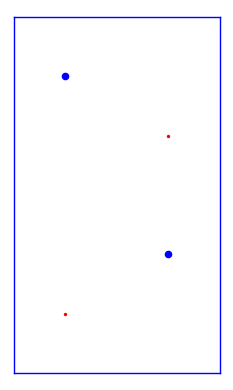

In [8]:
p = model.plot()
model.show(p)

In [9]:
model.ComputeForce(use_dxdy=False, use_d0 = True)
disp(model.PotentialEnergy())

<IPython.core.display.Math object>

In [10]:
model.ComputeForce(use_dxdy=False)
disp(model.PotentialEnergy())

<IPython.core.display.Math object>

In [11]:
model.ComputeForce(use_dxdy=True)
U = model.PotentialEnergy()
disp(U)

<IPython.core.display.Math object>

In [12]:
Ut2 = model.PotentialEnergyTaylor(2)
disp(Ut2)

<IPython.core.display.Math object>

Ut3 = model.PotentialEnergyTaylor(3)
disp(Ut3)

In [13]:
disp(model.KineticEnergy())

<IPython.core.display.Math object>

In [14]:
disp(model.Lagrangian())

<IPython.core.display.Math object>

In [15]:
disp(model.LagrangianTaylor(2))

<IPython.core.display.Math object>

In [16]:
Px, Py = model.Momentum()
disp(Px)
disp(Py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [17]:
px, py = model.momentum()
disp(px)
disp(py)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
eqs_x, eqs_y = model.EulerLagrange(2)

In [19]:
for eq_x in eqs_x:
    disp(eq_x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
for eq_y in eqs_y:
    disp(eq_y)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
len(eqs_x)

4

In [22]:
eqsi_x, eqsi_y, Ax, Ay, Amx, Amy = model.EulerLagrangeSolution(2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
M = GenerateMatrix(eqsi_x + eqsi_y, Amx + Amy)
disp(M)

<IPython.core.display.Math object>

In [24]:
det_M = M.det().factor()
disp(len(det_M.operands()))

<IPython.core.display.Math object>

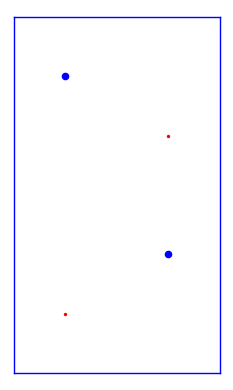

In [25]:
p = model.plot()
model.show(p)

In [26]:
# предполагаем моду в которой
# частоты одинаковых по массе
# атомов равны друг другу
M1 = M.subs(model.lambda_x[2] == +model.lambda_x[0]) \
      .subs(model.lambda_x[3] == +model.lambda_x[1]) \
      .subs(model.lambda_y[2] == +model.lambda_y[0]) \
      .subs(model.lambda_y[3] == +model.lambda_y[1])

In [27]:
det_M1 = M1.det().factor()
for det_M1_operand in det_M1.operands():
    print("")
    disp(det_M1_operand)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
disp(solve(det_M1 == 0, model.lambda_x[0]^2))

<IPython.core.display.Math object>

In [29]:
disp(solve(det_M1 == 0, model.lambda_x[1]^2))

<IPython.core.display.Math object>